# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import json

from pathlib import Path
from datetime import datetime

In [2]:
import shapely

In [3]:
import sklearn

In [4]:
import scipy

In [ ]:
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

In [225]:
import shapely.vectorized

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code", "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [7]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [8]:
floor_data_dir = os.path.join(INDOOR_COMPETITION_20_DIR, "data", "site1", "F2")
path_data_dir = os.path.join(floor_data_dir, "path_data_files")
floor_plan_filename = os.path.join(floor_data_dir, "floor_image.png")
floor_info_filename = os.path.join(floor_data_dir, "floor_info.json")
floor_map_filename  = os.path.join(floor_data_dir, "geojson_map.json")

## Data Extraction

In [9]:
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

In [10]:
path_filename = path_filenames[0]
path_datas = read_data_file(path_filename)

In [11]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [12]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Counting Steps

In [13]:
ts = path_datas.acce[:, 0].astype(np.int64)

acce_x = path_datas.acce[:, 1]
acce_x = (acce_x - np.mean(acce_x)) / np.std(acce_x)

acce_y = path_datas.acce[:, 2]
acce_y = (acce_y - np.mean(acce_y)) / np.std(acce_y)

acce_z = path_datas.acce[:, 3]
acce_z = (acce_z - np.mean(acce_z)) / np.std(acce_z)

acce = path_datas.acce[:, 1:]
acce = (acce - np.mean(acce, axis=0)) / np.std(acce, axis=0)

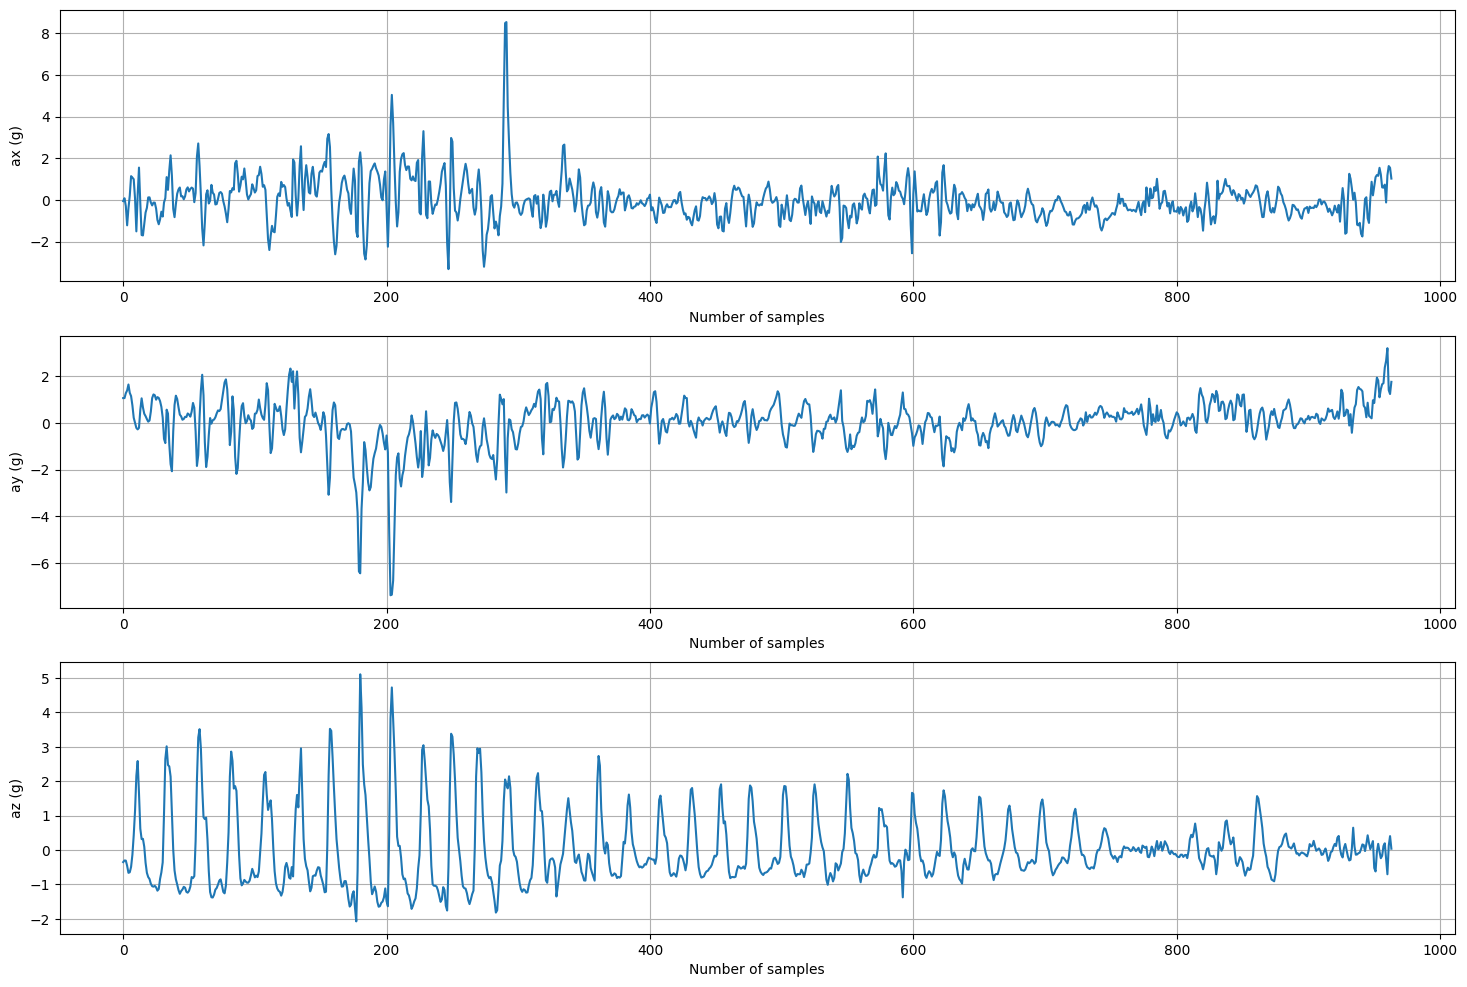

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 12),)

ax1.plot(acce_x)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(acce_y)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(acce_z)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [15]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m+t], axis=0), np.std(a[m:m+t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m+t:m+t*2], axis=0), np.std(a[m+t:m+t*2], axis=0)

  n_acf = np.sum((a[m:m+t] - mu_m) * (a[m+t:m+t*2] - mu_mt), axis=0) / t / sigma_m / sigma_mt

  return np.mean(n_acf)

In [16]:
accelerometer_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print(
    "The sampling frequency of accelerometer is {:.2f}Hz".format(accelerometer_sampling_freq)
)

The sampling frequency of accelerometer is 49.71Hz


In [17]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [18]:
STATE_IDLE = "IDLE"
STATE_WALKING = "WALKING"

def get_state(acce, m, prev_state=None, prev_t_opt=None):
  if prev_t_opt is not None:
    t_min, t_max = max(40, prev_t_opt - 10), min(100, prev_t_opt + 10)
  else:
    t_min, t_max = 40, 100
  
  n_acf, t_opt = max_norm_acf(acce, m=m, t_min=t_min, t_max=t_max)
  
  sigma = np.mean(np.std(acce[m:m+t_opt], axis=0))
  if sigma < 0.01:
    return STATE_IDLE, t_opt
  
  if n_acf > 0.7:
    return STATE_WALKING, t_opt
  
  return prev_state, t_opt


In [19]:
get_state(acce, m=50)

('WALKING', 49)

## Estimating Heading Offset Range

### Spectrum of Walking

In [20]:
def show_spectrum(signal_data, fs):
  n_samples = len(signal_data)
  duration = n_samples / fs
  t = np.linspace(0, duration, int(fs * duration), endpoint=False)

  frequencies, spectrum = scipy.signal.periodogram(signal_data, fs=fs)

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

  ax1.plot(t, signal_data)
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")
  ax1.set_title("Time Domain Signal")

  ax2.plot(frequencies, spectrum)
  ax2.set_xlabel("Frequency (Hz)")
  ax2.set_ylabel("Magnitude")
  ax2.set_title("Frequency Spectrum")

  plt.tight_layout()
  plt.show()

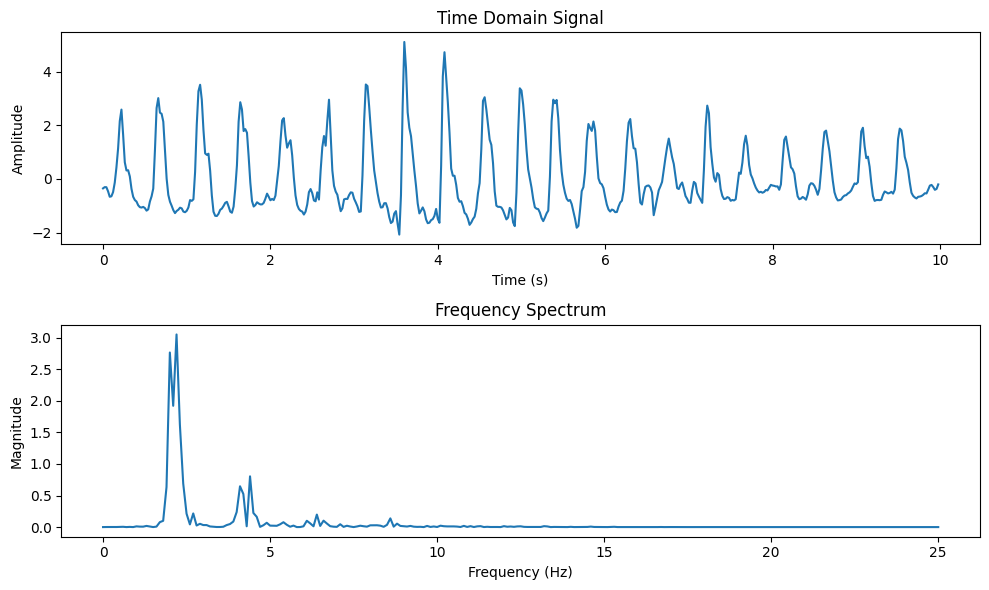

In [21]:
show_spectrum(acce_z[:500], fs=50)

In [22]:
def find_fundamental_frequency(frequencies, spectrum):
  idx = np.argmax(spectrum)
  return frequencies[idx], spectrum[idx]

In [23]:
def find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics=[2,3,4]):
  fundamental_frequency, amplitude = find_fundamental_frequency(frequencies, spectrum)
  harmonics_found = [harmonic for harmonic in harmonics if harmonic * fundamental_frequency in frequencies]
  return fundamental_frequency, amplitude, harmonics_found

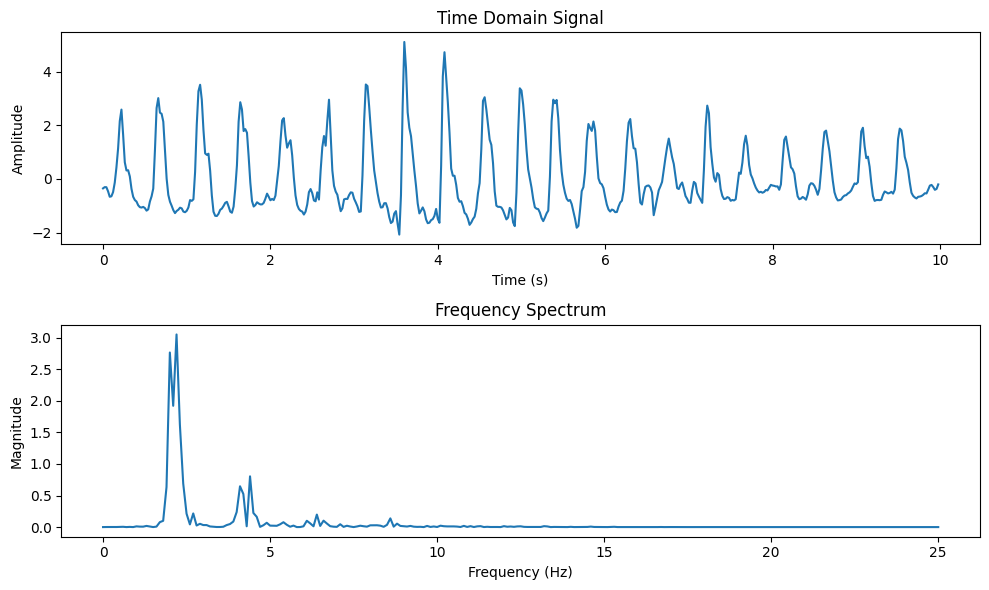

Fundamental Frequency: 2.2 Hz, Magnitude: 3.05
Harmonics Found: [2, 3, 4]


In [24]:
show_spectrum(acce_z[:500], fs=50)

# Find the fundamental frequency and its harmonics
frequencies, spectrum = scipy.signal.periodogram(acce_z[:500], fs=50)
harmonics = [2, 3, 4]
fundamental_frequency, amplitude, harmonics_found = find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics)

print(f"Fundamental Frequency: {fundamental_frequency} Hz, Magnitude: {amplitude:.2f}")
print(f"Harmonics Found: {harmonics_found}")

## Augmented Particle Filter

### Data Extraction

In [28]:
with open(floor_info_filename) as f:
  floor_info = json.load(f)

In [29]:
with open(floor_map_filename) as f:
  floor_map = json.load(f)

In [31]:
floor_info

{'map_info': {'height': 176.66380763697, 'width': 239.81749314504376}}

In [108]:
def parse_polygon_coordinates(geojson_feature):
  polygons = []

  feature_type = geojson_feature["geometry"]["type"]

  if feature_type == "MultiPolygon":
    for coord_set in geojson_feature["geometry"]["coordinates"]:
      polygons.append(np.array(coord_set[0], dtype=np.float64))
  
  elif feature_type == "Polygon":
    polygons.append(np.array(geojson_feature["geometry"]["coordinates"][0], dtype=np.float64))

  return polygons

In [109]:
def find_bound(floor_coordinates):
  assert len(floor_coordinates) > 0

  x_min, y_min = np.min(floor_coordinates[0], axis=0)
  x_max, y_max = np.max(floor_coordinates[0], axis=0)

  for coords in floor_coordinates[1:]:
    _x_min, _y_min = np.min(coords, axis=0)
    _x_max, _y_max = np.max(coords, axis=0)
    x_min = np.min([x_min, _x_min])
    y_min = np.min([y_min, _y_min])
    x_max = np.max([x_max, _x_max])
    y_max = np.max([y_max, _y_max])
  
  return x_min, y_min, x_max, y_max

In [157]:
def scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter,
              inplace=False):
  if not inplace:
    coords = coords.copy()

  coords[:, 0] = (coords[:, 0] - x_min) / (x_max - x_min) * width_meter
  coords[:, 1] = (coords[:, 1] - y_min) / (y_max - y_min) * height_meter
  
  return coords

In [158]:
def extract_floor_map_geometries(floor_map, floor_info):
  # Finding the bound of the floormap
  floor_coordinates = parse_polygon_coordinates(floor_map["features"][0])
  x_min, y_min, x_max, y_max = find_bound(floor_coordinates)

  width_meter = floor_info["map_info"]["width"]
  height_meter = floor_info["map_info"]["height"]

  # Scaling floormap
  for coords in floor_coordinates:
    scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)

  floor_polygons = [Polygon(coords) for coords in floor_coordinates]

  # Extract store polygons
  store_polygons = []

  for geojson_feature in floor_map["features"][1:]:
    polygons = parse_polygon_coordinates(geojson_feature)
    # In-place normalization
    for coords in polygons:
      scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
      store_polygons.append(Polygon(coords))
  
  return floor_polygons, store_polygons, x_min, y_min, x_max, y_max, width_meter, height_meter

In [159]:
%%time
floor_polygons, store_polygons, x_min, y_min, x_max, y_max, width_meter, height_meter = extract_floor_map_geometries(floor_map, floor_info)

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 9.95 ms


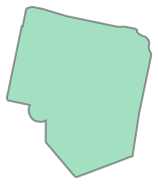

In [160]:
floor_polygons[0]

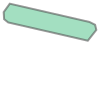

In [161]:
store_polygons[0]

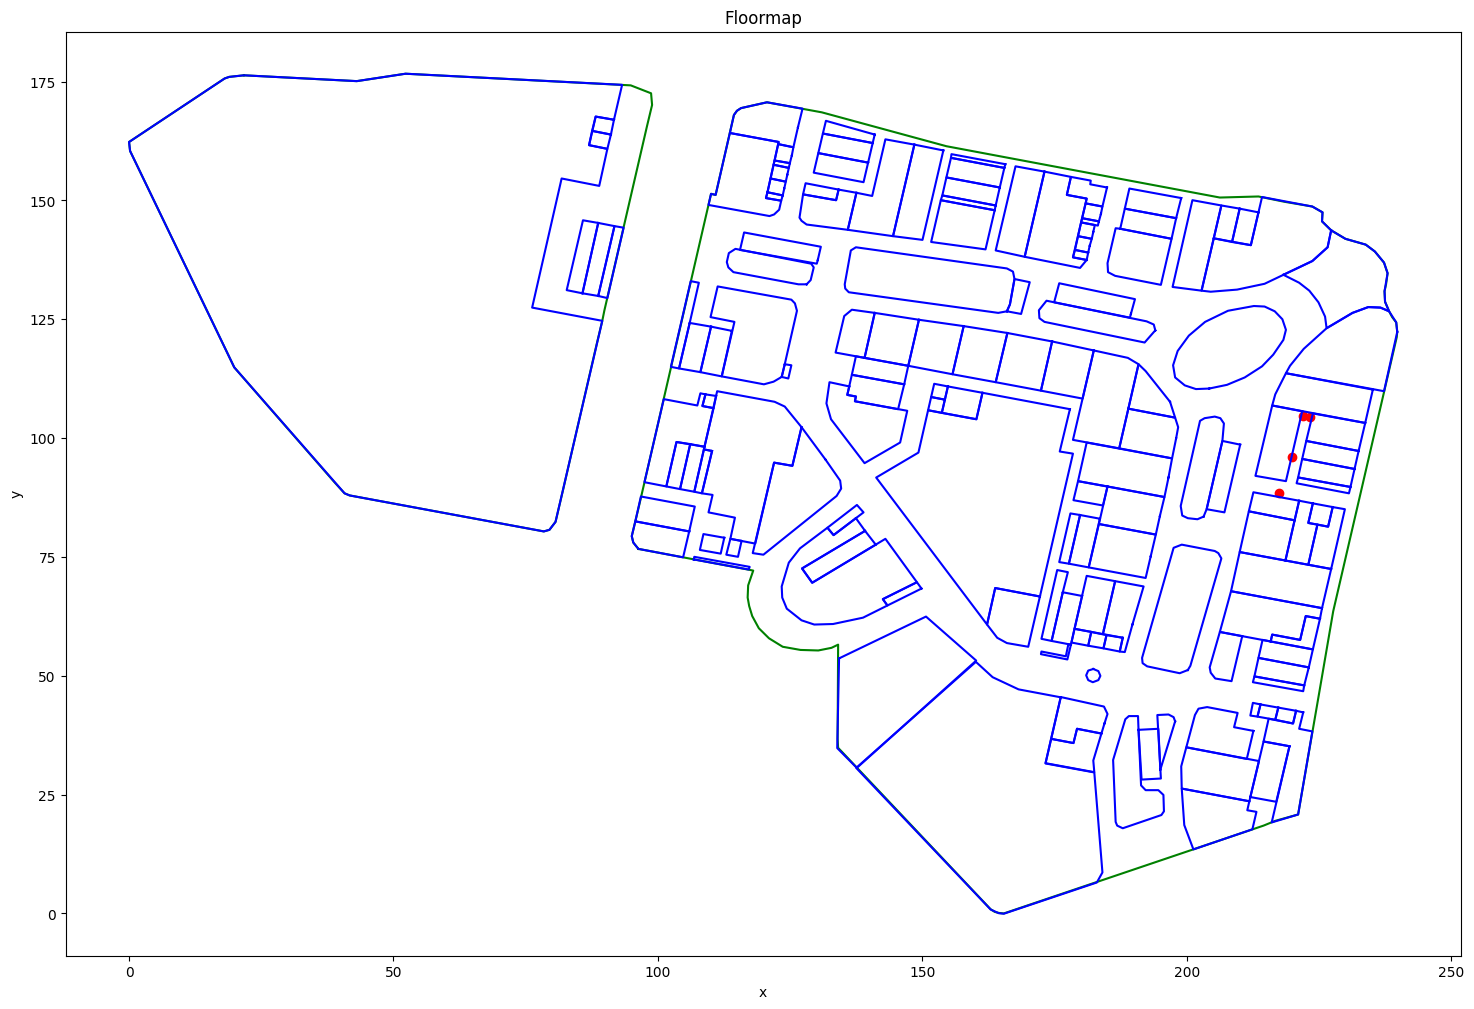

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
ax.scatter(gt_location[:, 0], gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

#### Search Space Extraction

* Search space is the space occupied by the floor excluding the space occupied by the stores.

In [247]:
union_floor_polygon = shapely_ops.unary_union(floor_polygons)
union_store_polygon = shapely_ops.unary_union(store_polygons)
floor_search_space = union_floor_polygon.difference(union_store_polygon)

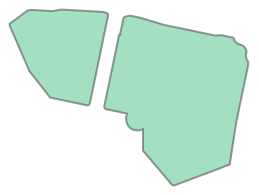

In [248]:
union_floor_polygon

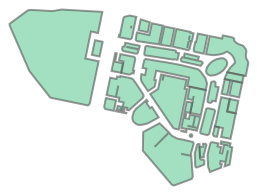

In [249]:
union_store_polygon

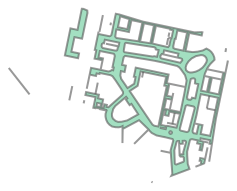

In [250]:
floor_search_space

In [251]:
# Generate search grid

grid_resolution = 2 # 5 meters
grid_xs = np.arange(0, width_meter, grid_resolution) + grid_resolution / 2
grid_ys = np.arange(0, height_meter, grid_resolution) + grid_resolution / 2

grid_x, grid_y = np.meshgrid(grid_xs, grid_ys)

In [252]:
search_space_mask = shapely.vectorized.contains(floor_search_space, grid_x, grid_y)
ss_x, ss_y = grid_x[search_space_mask], grid_y[search_space_mask]

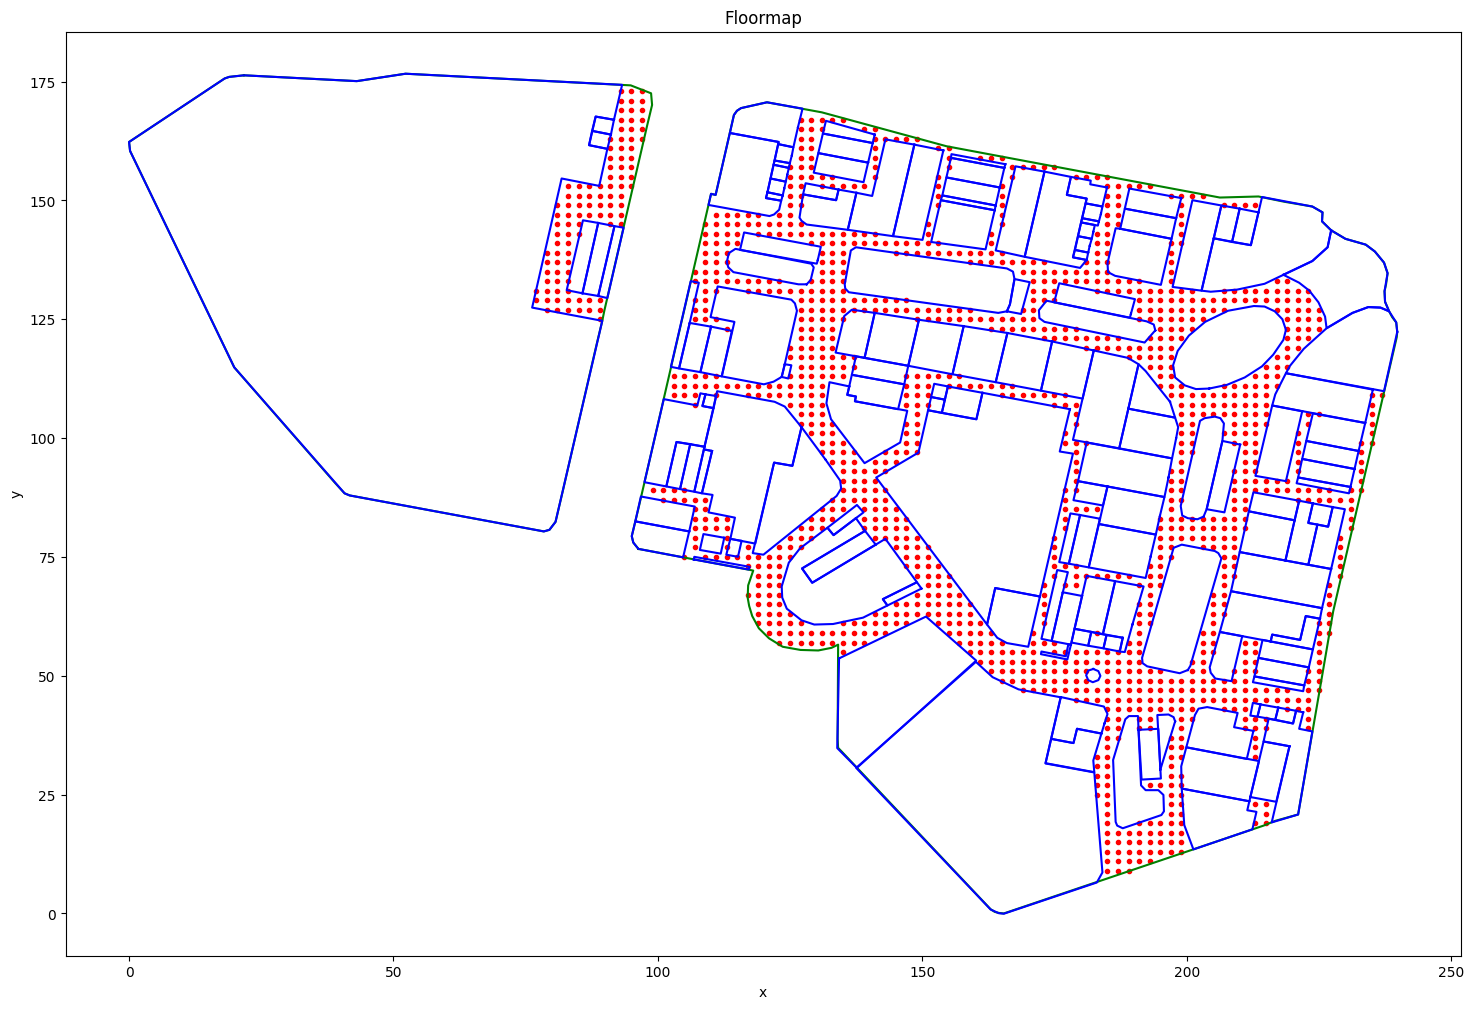

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding search grid
ax.scatter(ss_x, ss_y, marker=".", color="red", label="ss")

plt.ticklabel_format(useOffset=False)
plt.show()
